<a href="https://colab.research.google.com/github/dcorredor20/water_demand_forecasting/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/dcorredor20/water_demand_forecasting.git

  Cloning https://github.com/dcorredor20/water_demand_forecasting.git to /tmp/pip-req-build-nm243ghl
  Running command git clone -q https://github.com/dcorredor20/water_demand_forecasting.git /tmp/pip-req-build-nm243ghl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive
MyDrive


In [3]:
from water_demand_forecasting import custom_plots
from water_demand_forecasting.wdf_model import WDF_Model
import tensorflow
import time
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Conv1D, Concatenate,BatchNormalization, ReLU, Add, ZeroPadding1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [4]:
# variables_model
VARIABLES = ["case_study"]
CONFIG = {
    "case_study":
      {"train": '/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS2_14.txt',
      "test": '/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS2_15.txt'},
      "days": 
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/days2014.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/days2015.csv'},

    "precipitation":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/Prec2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/Prec2015CS2.csv'},

    "relative_humidity":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/RH2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/RH2015CS2.csv'},

    "temperature":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/MaxTem2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/MaxTem2015CS2.csv'}} 
T = 168

In [5]:
Xtra, Ytra, Xval, Yval, Xtest, Ytest, scx, scy = WDF_Model.data_preprocessing(
    VARIABLES, CONFIG, lookback=T
)

In [6]:
print(Xtra.shape)
print(Ytra.shape)
print(Xval.shape)
print(Yval.shape)
print(Xtest.shape)
print(Ytest.shape)

(6426, 168)
(6426, 24)
(2142, 168)
(2142, 24)
(8568, 168)
(8568, 24)


In [7]:
Xtra

array([[0.74106604, 0.74796691, 0.61002716, ..., 0.63967561, 0.69721788,
        0.79867589],
       [0.17231393, 0.35764364, 0.57480946, ..., 0.19402526, 0.18409822,
        0.14867277],
       [0.50465189, 0.63126791, 0.67476816, ..., 0.49403151, 0.46022302,
        0.45601542],
       ...,
       [0.52486139, 0.47360925, 0.34190456, ..., 0.68573145, 0.70656171,
        0.57926486],
       [0.78986771, 0.78887902, 0.65886387, ..., 0.59386506, 0.60777443,
        0.67042539],
       [0.41362402, 0.39764464, 0.33287862, ..., 0.7006996 , 0.64862896,
        0.49922531]])

In [8]:
earlyStopping= EarlyStopping(monitor='val_loss', patience=8, verbose=1,  min_delta=1e-4, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=1e-3, mode='min')
callbacks = [earlyStopping, mcp_save, lr_reduced]

In [9]:
# LSTM model
i = Input(shape=(T,len(VARIABLES)), name='Input layer')
x = LSTM(64, activation='tanh', return_sequences=True)(i)
x = LSTM(64, activation='tanh', return_sequences=False)(x)

x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name='Hidden1')(x)
x = Dense(24, activation='linear', name='Output')(x)

model = Model(i,x)
print(model.summary())

# compile
optimizer = Adam(learning_rate = 0.005)
model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

# train
start = time.time()
r = model.fit(Xtra, Ytra, verbose = 1, validation_data=(Xval, Yval), epochs=200, callbacks=callbacks, batch_size=32)
end = time.time()
print('Total training time: ', end-start)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input layer (InputLayer)     [(None, 168, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 168, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Hidden1 (Dense)              (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 24)                1560      
Total params: 55,640
Trainable params: 55,640
Non-trainable params: 0
_________________________________________________________

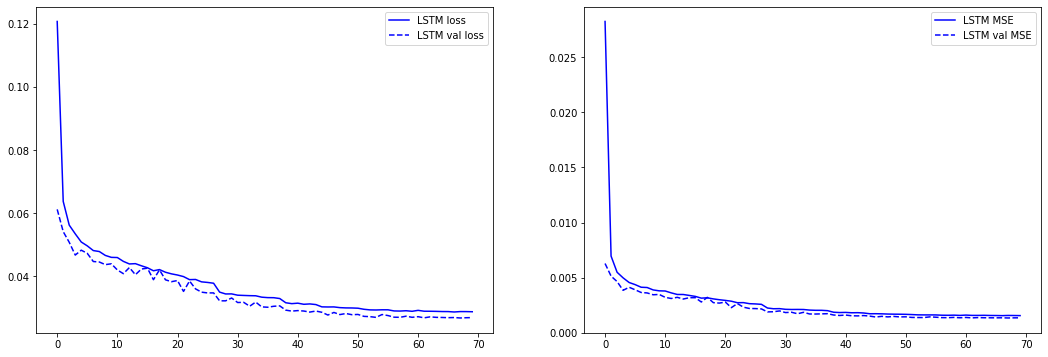

In [10]:
custom_plots.loss_plot(r, 'LSTM', color = 'b')

In [11]:
def print_metrics(y,ypred,dataset):
  y = scy.inverse_transform(y) 
  ypred = scy.inverse_transform(ypred)
  print(f'{dataset}\t\tRMSE:{mean_squared_error(y,ypred)**0.5:.3f}\tMAE:{mean_absolute_error(y,ypred):.3f}\tR2:{r2_score(y,ypred):.3f}')

print_metrics(Ytra.reshape(-1,1),model.predict(Xtra).reshape(-1,1),'Train')
print_metrics(Yval.reshape(-1,1),model.predict(Xval).reshape(-1,1),'Val')
print_metrics(Ytest.reshape(-1,1),model.predict(Xtest).reshape(-1,1),'Test')

Train		RMSE:35.713	MAE:25.970	R2:0.967
Val		RMSE:36.671	MAE:26.926	R2:0.965
Test		RMSE:61.612	MAE:45.480	R2:0.896


In [12]:
Y_hatval = model.predict(Xval)
Y_val = scy.inverse_transform(Yval)
Yhatval = scy.inverse_transform(Y_hatval)
dat1y1 = pd.DataFrame(Y_val)
dat2y1 = pd.DataFrame(Yhatval)
e = 100*np.sum(np.abs((dat1y1 - dat2y1)/np.mean(dat1y1, axis = 0)), axis = 0)/len(dat1y1)
print(f'MAE% Y1 = {e.mean()}')

MAE% Y1 = 2.876999618781621


In [13]:
Y_hat = model.predict(Xtest)
Y_test = scy.inverse_transform(Ytest)
Yhat = scy.inverse_transform(Y_hat)
dat1y2 = pd.DataFrame(Y_test)
dat2y2 = pd.DataFrame(Yhat)
e = 100*np.sum(np.abs((dat1y2 - dat2y2)/np.mean(dat1y2, axis = 0)), axis = 0)/len(dat1y2)
print(f'MAE% Y2 = {e.mean()}')

MAE% Y2 = 4.702506286696316
